In [282]:
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np

In [289]:
df = pd.read_csv('T_games_dataset.csv')

In [290]:
print(f'Number of rows: {len(df)}')
print(f'Unique clients: {len(df["client_id"].unique())}')

Number of rows: 88699
Unique clients: 41298


In [291]:
df['order_date'] = pd.to_datetime(df['order_day'])
df.drop('order_day', axis=1, inplace=True)
df['order_year'] = df['order_date'].dt.year
df['order_month'] = df['order_date'].dt.month
df['order_day'] = df['order_date'].dt.day
df['purchased_on_discount'] = df['category_name'] == 'Скидки'

df['good_type'] = df['good_name'].apply(
    lambda x: 'DLC' if 'dlc' in x.lower() else 'Game')
df['is_DLC'] = df['good_type'] == 'DLC'

bundle_tags = ['edition', 'pack', 'collection', 'bundle', 'antology']

df['is_bundle'] = df['good_name'].apply(lambda x: (any(tag in x.lower() for tag in bundle_tags)) and ('dlc' not in x.lower()))
bundle_purchases = df[df['is_bundle']].copy()
bundle_purchases['is_DLC'] = True
bundle_purchases['good_name'] = bundle_purchases['good_name'].apply(
    lambda x: x + ' (dlc from bundle)')
df = pd.concat([df, bundle_purchases], axis=0)

edu_lvl_grade = {'SCH': 1, 'UGR': 2, 'GRD': 3, 'PGR': 4, 'ACD': 5}
edu_lvl_by_grade = {v: k for k, v in edu_lvl_grade.items()}

df['edu_lvl_grade'] = df['education_level'].map(edu_lvl_grade)

min_age_by_id = df.groupby('client_id')['age'].min()
df['min_age'] = df['client_id'].map(min_age_by_id)

max_age_by_id = df.groupby('client_id')['age'].max()
df['max_age'] = df['client_id'].map(max_age_by_id)

highest_edu_lvl_by_id = df.groupby('client_id')['education_level'].apply(lambda x: edu_lvl_by_grade[x.map(edu_lvl_grade).max()])

df['edu_lvl_grade'] = df['client_id'].map(edu_lvl_grade)

edu_lvls_by_id = df.groupby('client_id')['education_level'].apply(lambda x: x.drop_duplicates().tolist())

age_by_edu_lvl_treshold = {'SCH': 10, 'UGR': 16, 'GRD': 21, 'PGR': 23, 'ACD': 25}

## Очистка
Удаляем пользователей с разностью между минимальным и максимальным возрастом > 3 лет

Убираем строки с повторяющимися значениями (клиент, игра)

Образование берём максимальное у каждого клиента

In [292]:
df = df[df['max_age'] == df['min_age']]
df = df[df['age'] >= 14]
df.drop_duplicates(subset=['client_id', 'good_name'], inplace=True)

client_ids = df['client_id'].drop_duplicates()

In [293]:
print(f'Number of rows: {len(df)}')
print(f'Unique clients: {len(df["client_id"].unique())}')

Number of rows: 93307
Unique clients: 40016


In [294]:
def correct_edu_lvl(cliend_id):
    age = min_age_by_id[cliend_id]
    max_lvl = max([edu_lvl_grade[lvl] for lvl in edu_lvls_by_id[cliend_id]])
    while age < age_by_edu_lvl_treshold[edu_lvl_by_grade[max_lvl]]:
        max_lvl -= 1        
    return edu_lvl_by_grade[max_lvl]

df['education_level'] = df['client_id'].map(correct_edu_lvl)

In [295]:
mean_income_by_id = df.groupby('client_id')['monthly_income_amt'].mean()

most_common_age_by_id = df.groupby('client_id')['age'].apply(lambda x: x.value_counts().index[0])

dlc_to_all_ratio_by_id = df.groupby('client_id')['is_DLC'].mean()

count_by_id = df.groupby('client_id')['good_name'].count()

In [296]:
def plot_reg(x, y, precision=2, **kwargs):
    w1 = np.cov(x, y, ddof=0)[0, 1] / np.var(x, ddof=0)
    w0 = np.mean(y) - w1 * np.mean(x)
    plt.plot(x, w0 + w1 * x, color='red', label=f'y = {w0:.{precision}f} + x * {w1:.{precision}f}', **kwargs)
    plt.legend()

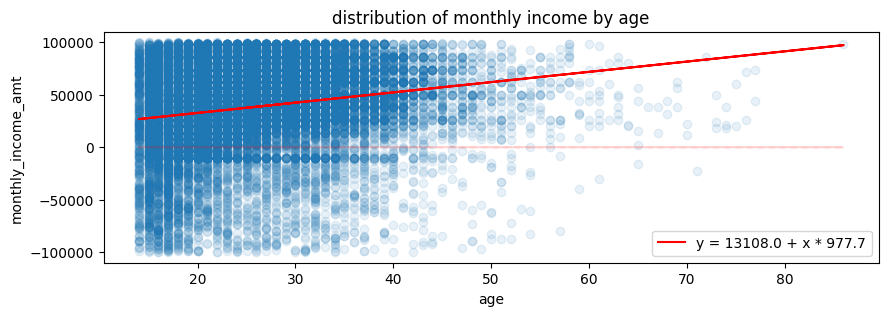

In [297]:
# plot distribution of monthly_income_amt by age
plt.figure(figsize=(10, 3))
df1 = pd.DataFrame({'age' : client_ids.map(most_common_age_by_id), 'mean income' : client_ids.map(mean_income_by_id)})
df1 = df1[abs(df1['mean income']) < 100000]
plt.scatter(df1['age'], df1['mean income'], alpha=0.1)
plt.plot(df1['age'], np.zeros(df1.shape[0]), alpha=0.2, color='red', linestyle='--')
plt.xlabel('age')
plt.ylabel('monthly_income_amt')
plt.title('distribution of monthly income by age')
plot_reg(df1['age'], df1['mean income'], 1)

<AxesSubplot: xlabel='age'>

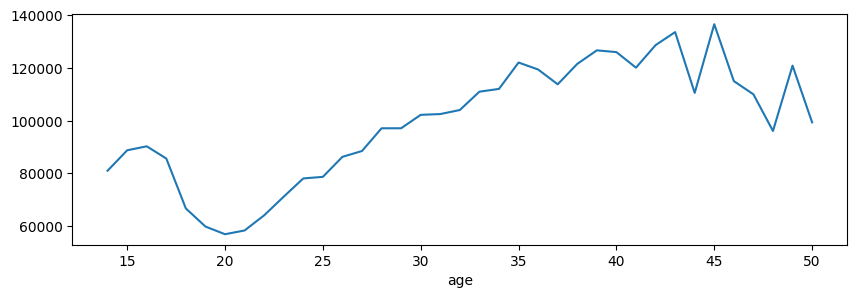

In [298]:
plt.figure(figsize=(10, 3))
df1 = pd.DataFrame({'age' : client_ids.map(most_common_age_by_id), 'mean income' : client_ids.map(mean_income_by_id)})
df1 = df1[(14 <= df1['age']) & (df1['age'] <= 50)]
df1.groupby('age')['mean income'].mean().plot()

In [299]:
df.groupby(['client_id', 'good_name']).size().value_counts()

1    93307
dtype: int64

<AxesSubplot: xlabel='mean age', ylabel='edu_lvl'>

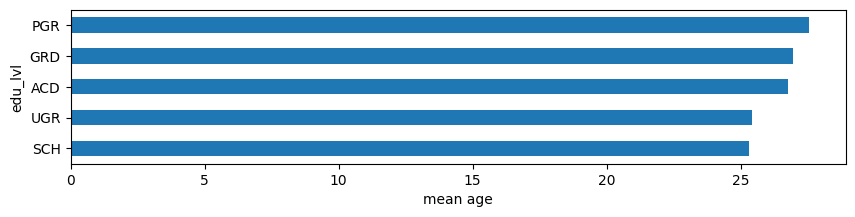

In [300]:
plt.figure(figsize=(10, 2))
df1 = pd.DataFrame({'age': client_ids.map(most_common_age_by_id), 'edu_lvl': client_ids.map(highest_edu_lvl_by_id)})
df1.groupby('edu_lvl')['age'].mean().sort_values().plot(kind='barh', xlabel='mean age')

<AxesSubplot: xlabel='mean income', ylabel='edu_lvl'>

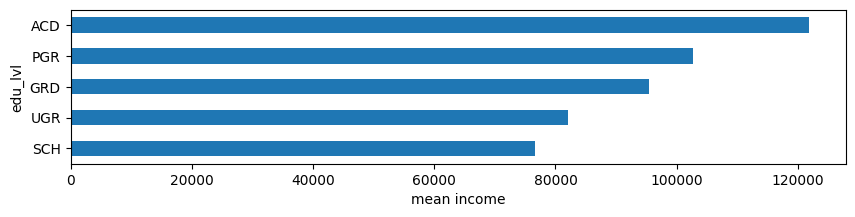

In [301]:
plt.figure(figsize=(10, 2))
df1 = pd.DataFrame({'edu_lvl': client_ids.map(highest_edu_lvl_by_id), 'monthly_income_amt': client_ids.map(mean_income_by_id)})
df1.groupby('edu_lvl')['monthly_income_amt'].mean().sort_values().plot(kind='barh', xlabel='mean income')

<AxesSubplot: xlabel='age', ylabel='dlc_to_all_ratio'>

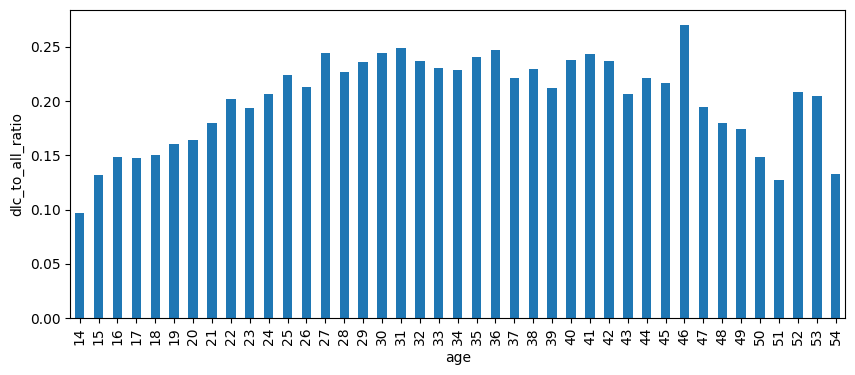

In [302]:
plt.figure(figsize=(10, 4))
df1 = pd.DataFrame({'age': client_ids.map(most_common_age_by_id), 'dlc_to_all_ratio': client_ids.map(dlc_to_all_ratio_by_id)})
df1 = df1[(df1['age'] >= 14) & (df1['age'] < 55)]
df1.groupby('age')['dlc_to_all_ratio'].mean().plot(kind='bar', ylabel='dlc_to_all_ratio', xlabel='age')

Text(0, 0.5, 'Количество клиентов')

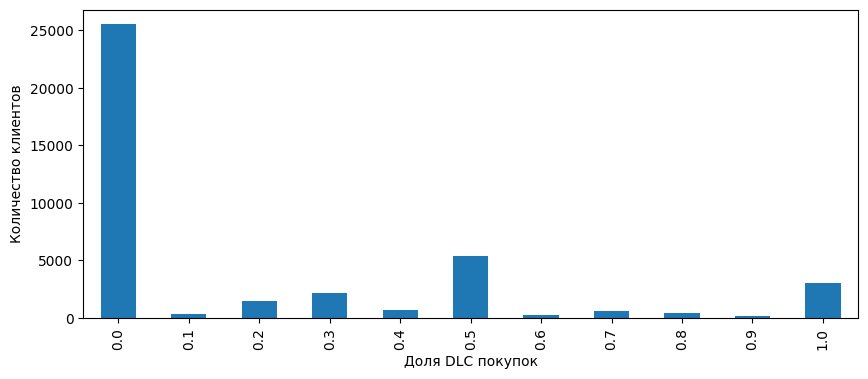

In [303]:
plt.figure(figsize=(10, 4))
df1 = pd.DataFrame({'age': client_ids.map(most_common_age_by_id),
                   'dlc_to_all_ratio': client_ids.map(dlc_to_all_ratio_by_id)})
df1 = df1[(df1['age'] >= 14) & (df1['age'] < 55)]
df1['dlc_to_all_ratio'].apply(lambda x: round(x, 1)).value_counts().sort_index().plot(kind='bar')
plt.xlabel('Доля DLC покупок')
plt.ylabel('Количество клиентов')

<AxesSubplot: title={'center': 'Распределение количества покупок на клиента'}, xlabel='Количество покупок'>

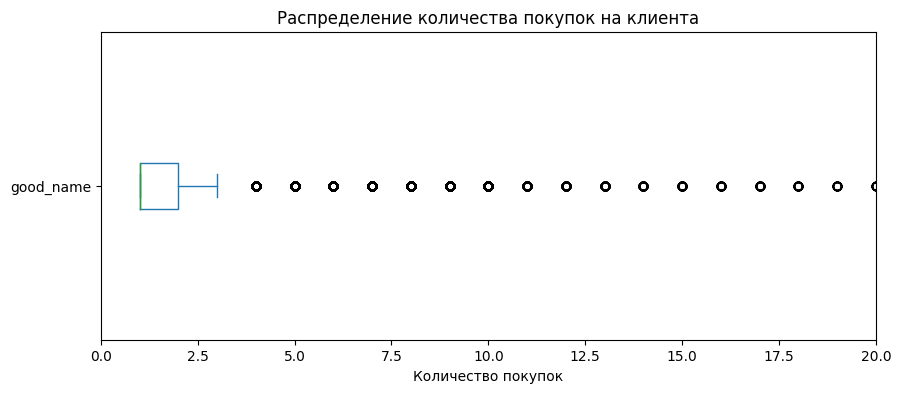

In [304]:
plt.figure(figsize=(10, 4))
count_by_id.plot(kind='box', vert=False, xlim=(0, 20), xlabel='Количество покупок', title='Распределение количества покупок на клиента')

In [305]:
count_by_id[count_by_id > 10].sum()

18099

<AxesSubplot: xlabel='age', ylabel='count'>

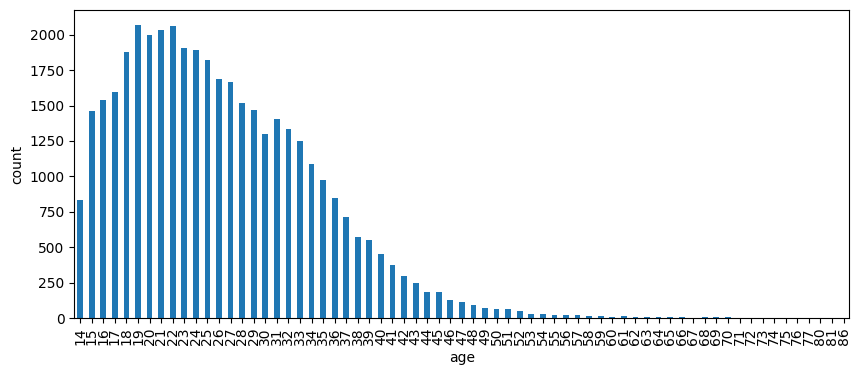

In [306]:
plt.figure(figsize=(10, 4))
client_ids.map(most_common_age_by_id).value_counts().sort_index().plot(kind='bar', xlabel='age', ylabel='count')

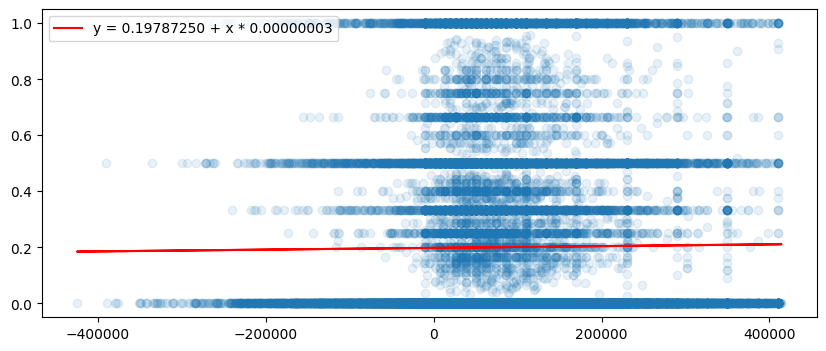

In [307]:
plt.figure(figsize=(10, 4))
df1 = pd.DataFrame({'income': client_ids.map(mean_income_by_id), 'dlc_to_all_ratio': client_ids.map(dlc_to_all_ratio_by_id)})
treshold = df1['income'].quantile(0.99)
df1 = df1[df1['income'] < treshold]
plt.scatter(df1['income'], df1['dlc_to_all_ratio'], alpha=0.1)
plot_reg(df1['income'], df1['dlc_to_all_ratio'], 8)

In [308]:
incomes = client_ids.map(mean_income_by_id)
len(incomes[incomes < 0]) / len(incomes)

0.11622850859656138

In [309]:
df1 = pd.DataFrame({'income': client_ids.map(mean_income_by_id), 'dlc_to_all_ratio': client_ids.map(dlc_to_all_ratio_by_id), 'age': client_ids.map(most_common_age_by_id), 'edu_lvl': client_ids.map(highest_edu_lvl_by_id).apply(lambda x: edu_lvl_grade[x])})
# df1 = df1[(df1['age'] >= 14) & (df1['age'] < 40)]
df1.corr()

,income,dlc_to_all_ratio,age,edu_lvl
income,1.000000,0.007101,0.125168,0.070834
dlc_to_all_ratio,0.007101,1.000000,0.093240,0.053182
age,0.125168,0.093240,1.000000,0.091650
edu_lvl,0.070834,0.053182,0.091650,1.000000


<AxesSubplot: xlabel='mean dlc_to_all_ratio', ylabel='edu_lvl'>

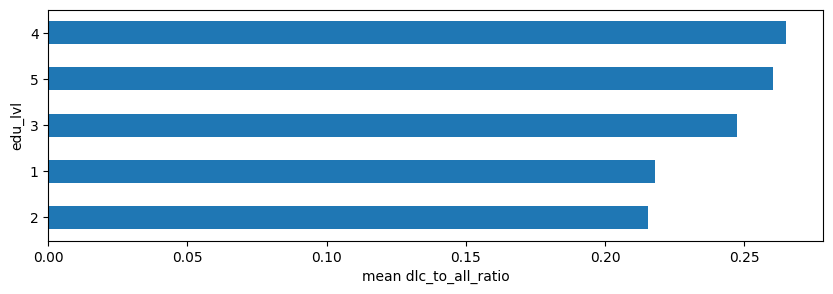

In [310]:
plt.figure(figsize=(10, 3))
df1 = pd.DataFrame({'dlc_to_all_ratio': client_ids.map(dlc_to_all_ratio_by_id), 'edu_lvl' : client_ids.map(highest_edu_lvl_by_id).apply(lambda x: edu_lvl_grade[x]), 'age': client_ids.map(most_common_age_by_id)})
df1 = df1[(df1['age'] >= 27) & (df1['age'] < 45)]
df1.groupby('edu_lvl')['dlc_to_all_ratio'].mean().sort_values().plot(kind='barh', xlabel='mean dlc_to_all_ratio')